In [6]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../")
import match
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def check(matrix, tensor, check_grad=False):
    m = tensored(matrix, get_grad=check_grad)
    t = tensor.grad if check_grad else tensor
    assert torch.allclose(m, t, rtol=1e-02, atol=1e-05), "Not close."


def tensored(matrix, requires_grad=False, get_grad=False):
    mdata = matrix.grad.data if get_grad else matrix.data.data
    return torch.tensor(mdata, requires_grad=requires_grad)

In [8]:
N = 5
n0 = 4
n1 = 3
n2 = 6
n3 = 1

x = match.randn(N, n0)
y = match.randn(N, 1)

# Layer 1
w1 = match.randn(n1, n0)
b1 = match.randn(n1, 1)

z1 = x @ w1.T + b1.T
a1 = z1.relu()

# Layer 2
w2 = match.randn(n2, n1)
b2 = match.randn(n2, 1)

z2 = a1 @ w2.T + b2.T
a2 = z2.relu()

# Layer 3
w3 = match.randn(n3, n2)
b3 = match.randn(n3, 1)

z3 = a2 @ w3.T + b3.T
a3 = z3.sigmoid()

# Loss mean-square-error
loss = ((a3 - y) ** 2).mean()
loss.backward()

In [9]:
xt = tensored(x, requires_grad=True)
yt = tensored(y, requires_grad=True)

# Layer t1
wt1 = tensored(w1, requires_grad=True)
bt1 = tensored(b1, requires_grad=True)

zt1 = xt @ wt1.T + bt1.T
at1 = zt1.relu()

# Layer t2
wt2 = tensored(w2, requires_grad=True)
bt2 = tensored(b2, requires_grad=True)

zt2 = at1 @ wt2.T + bt2.T
at2 = zt2.relu()

# Layer t3
wt3 = tensored(w3, requires_grad=True)
bt3 = tensored(b3, requires_grad=True)

zt3 = at2 @ wt3.T + bt3.T
at3 = zt3.sigmoid()

# Loss mean-square-error
losst = ((at3 - yt) ** 2).mean()
losst.backward()

In [10]:
check(z1, zt1)
check(a1, at1)

check(z2, zt2)
check(a2, at2)

check(z3, zt3)
check(a3, at3)

check(loss, losst)

check(y, yt, check_grad=True)

check(w3, wt3, check_grad=True)
check(b3, bt3, check_grad=True)

check(w2, wt2, check_grad=True)
check(b2, bt2, check_grad=True)

check(w1, wt1, check_grad=True)
check(b1, bt1, check_grad=True)

check(x, xt, check_grad=True)

In [11]:
m1 = match.randn(3, 2)
t1 = tensored(m1, requires_grad=True)
check(m1, t1)

m2 = match.randn(3, 2)
t2 = tensored(m2, requires_grad=True)
check(m2, t2)

m3 = m1 * m2 * -1 + 5
t3 = t1 * t2 * -1 + 5
check(m3, t3)

m4 = m3.sigmoid()
t4 = t3.sigmoid()
check(m4, t4)

m5 = (m4 / m1) ** 3
t5 = (t4 / t1) ** 3
check(m5, t5)

m6 = m5.sigmoid()  # relu()
t6 = t5.sigmoid()  # relu()
check(m6, t6)

mf = m6
tf = t6
check(mf, tf)

m = mf.sum()
t = tf.sum()
check(m, t)

m.backward()
t.backward()
check(m1, t1, check_grad=True)
check(m2, t2, check_grad=True)

In [12]:
linear = match.nn.Linear(10, 14)
relu = match.nn.ReLU()

x = match.randn(5, 10)
z = linear(x)
a = relu(z)

In [14]:
lineart = torch.nn.Linear(10, 14)
lineart.weight = torch.nn.Parameter(tensored(linear.A))
lineart.bias = torch.nn.Parameter(tensored(linear.b).squeeze())
relut = torch.nn.ReLU()

xt = tensored(x)
zt = lineart(xt)
at = relut(zt)

In [15]:
check(z, zt)
check(a, at)

In [76]:
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

jtplot.style(context="talk")


def plot(x, yt=None, yp=None, ypl=None):
    if yt:
        plt.plot(x.T.data.data[0], yt.T.data.data[0], label="Target")
    if yp:
        ypl = "Prediction" if not ypl else ypl
        plt.plot(x.T.data.data[0], yp.T.data.data[0], linestyle="--", label=ypl)
    plt.legend()

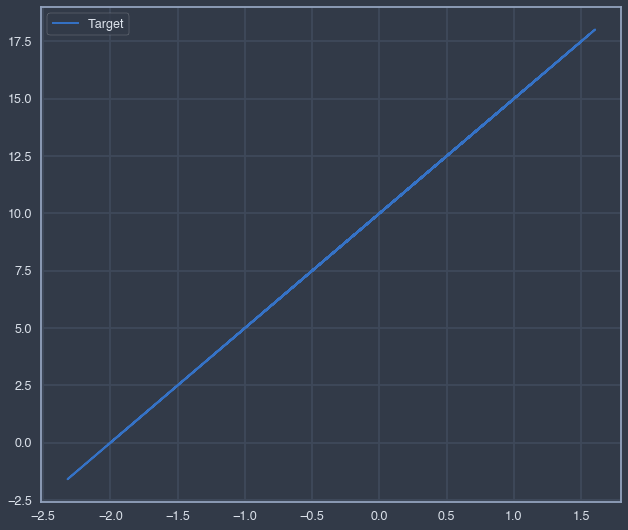

In [77]:
n = 50
d = 1

x = match.randn(n, d)  # uniform
y_targ = x * 5 + 10
plot(x, y_targ)

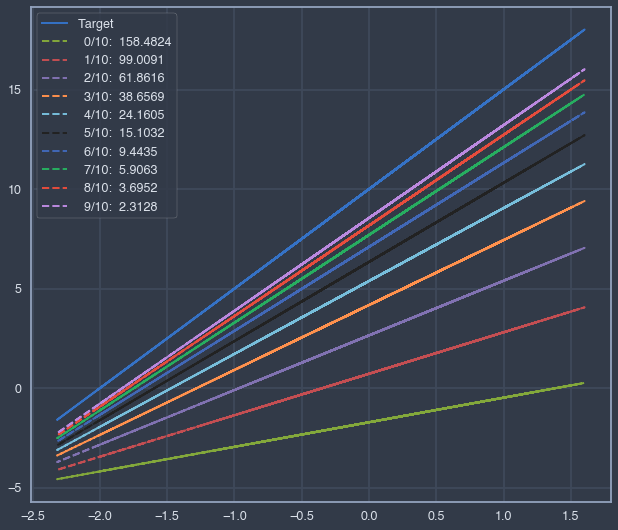

In [78]:
plot(x, y_targ)

num_epochs = 10
learning_rate = 0.1

loss_fcn = match.nn.MSELoss()
model = match.nn.Linear(1, 1)

for epoch in range(num_epochs):
    y_pred = model(x)
    loss = loss_fcn(y_pred, y_targ)
    
    plot(x, yp=y_pred, ypl=f"{epoch:>3}/{num_epochs}: {loss}")

    model.zero_grad()
    loss.backward()
    
    for param in model.parameters():
        param.data = param.data - learning_rate * param.grad

In [32]:
n = 50
d = 2

x = match.randn(n, d)  # uniform
y_targ = x * 5 + 10
plot(x, y_targ)

(50, 1)